In [110]:
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from scipy.interpolate import interp1d
from scipy.spatial.distance import directed_hausdorff
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
# import scienceplots
# plt.style.use('science')

class DifferentialDriveRobot:
    def __init__(self, R, L):
        self.R = R  # Raio da roda
        self.L = L  # Distância entre as rodas
        print('self.R', self.R)
        print('self.L', self.L)
        
        # Estados iniciais
        self.x = 0
        self.y = 0
        self.theta = 0

    def update(self, v_R, v_L, dt):
        v = (self.R / 2) * (v_R + v_L)
        omega = (self.R / self.L) * (v_R - v_L)
        
        self.theta += omega * dt
        self.x += v * np.cos(self.theta) * dt
        self.y += v * np.sin(self.theta) * dt


class MPCController:
    """
    ### MPC Controller Class \n
    :param DifferentialDriveRobot robot: A robot model
    :param int N: Prediction Horizon
    :param float Q: Penalty for tracking error
    :param float R: Penalty for control effort
    :param float dt: Time interval
    :param max_margin: A margin of robot maximum offset
    """
    def __init__(self, robot, N, Q, R, dt, max_margin):
        self.robot = robot
        self.N = N  
        self.Q = Q  
        self.R = R  
        self.dt = dt
        self.max_margin = max_margin  # Distância máxima permitida da trajetória de referência

    def solve(self, x_ref, y_ref, disable_constrain = False):
        model = pyo.ConcreteModel()

        model.N = self.N
        model.dt = self.dt
        model.Q = self.Q
        model.R = self.R
        model.x_ref = x_ref
        model.y_ref = y_ref

        # Variáveis de otimização
        model.v_R = pyo.Var(range(model.N), domain=pyo.Reals)
        model.v_L = pyo.Var(range(model.N), domain=pyo.Reals)

        # Estados
        model.x = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)
        model.y = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)
        model.theta = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)

        # Estados iniciais
        model.x[0].fix(self.robot.x)
        model.y[0].fix(self.robot.y)
        model.theta[0].fix(self.robot.theta)

        # Variável auxiliar para a Distância de Hausdorff
        model.hausdorff_dist = pyo.Var()

        # Função custo
        def objective_rule(model):
            cost = 0
            for t in range(1, model.N):
                cost += model.Q * ((model.x[t] - model.x_ref[t])**2 + (model.y[t] - model.y_ref[t])**2)
                # cost += model.R * (model.v_R[t]**2 + model.v_L[t]**2)
                # cost += model.R * ((model.v_R[t] - model.v_L[t])**2)
                cost += model.R * ((model.v_R[t] - model.v_R[t-1])**2 + (model.v_L[t] - model.v_L[t-1])**2)
   
            return cost
        
        model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

        # Restrições de dinâmica
        model.dynamics = pyo.ConstraintList()
        for t in range(model.N):
            v = (self.robot.R / 2) * (model.v_R[t] + model.v_L[t])
            omega = (self.robot.R / self.robot.L) * (model.v_R[t] - model.v_L[t])
            model.dynamics.add(model.x[t+1] == model.x[t] + v * pyo.cos(model.theta[t] + omega) * model.dt)
            model.dynamics.add(model.y[t+1] == model.y[t] + v * pyo.sin(model.theta[t] + omega) * model.dt)
            model.dynamics.add(model.theta[t+1] == model.theta[t] + omega * model.dt)

        if not disable_constrain:
            # Limites das variáveis de controle
            def control_limits_rule_R(model, t):
                return (-1, model.v_R[t], 1)
            
            def control_limits_rule_L(model, t):
                return (-1, model.v_L[t], 1)

            model.control_limits_R = pyo.Constraint(range(model.N), rule=control_limits_rule_R)
            model.control_limits_L = pyo.Constraint(range(model.N), rule=control_limits_rule_L)

            # Hausdorff_constraint of margin
            # def hausdorff_constraint(model):
            #     # Listas de pontos da trajetória atual e da referência
            #     traj_pred = [(model.x[i].value, model.y[i].value) for i in range(self.N)]
            #     traj_ref = [(model.x_ref[i], model.y_ref[i]) for i in range(self.N)]

            #     # Calcula a Distância de Hausdorff em ambas direções
            #     hd_dist_1 = directed_hausdorff(traj_pred, traj_ref)[0]
            #     hd_dist_2 = directed_hausdorff(traj_ref, traj_pred)[0]
                
            #     # Define a Distância de Hausdorff como o máximo entre as duas direções
            #     model.hausdorff_dist.set_value(max(hd_dist_1, hd_dist_2))

            #     # Restrições para garantir que a Distância de Hausdorff fique dentro do limite
            #     return model.hausdorff_dist <= self.max_margin

            # Adiciona a restrição de Hausdorff ao modelo
            # model.hausdorff_constraint = pyo.Constraint(rule=hausdorff_constraint)

        # Solver
        solver = SolverFactory('ipopt')
        result = solver.solve(model, tee=False)

        # Extrair os valores de controle resultantes
        out_X = [model.x[i]() for i in range(self.N)]
        out_Y = [model.y[i]() for i in range(self.N)]

        out_v_R = [model.v_R[i]() for i in range(self.N)]
        out_v_L = [model.v_L[i]() for i in range(self.N)]
        out_theta = [model.theta[i]() * 180/np.pi for i in range(self.N)]
        out_omega = [(self.robot.R / self.robot.L) * (model.v_R[i]() - model.v_L[i]())*180/np.pi for i in range(self.N)]
        
        print('out_X', out_X)
        print('out_Y', out_Y)
        print('out_v_R', out_v_R)
        print('out_v_L', out_v_L)
        print('out_theta', out_theta)
        print('out_omega', out_omega)
        return model.v_R[0].value, model.v_L[0].value, [out_X, out_Y], [out_v_R, out_v_L]

# Parâmetros do robô
radius_wheel = 0.05     # Raio da roda em metros
distance_wheel = 0.10   # Distância entre as rodas em metros

# Criar instância do robô diferencial
robot = DifferentialDriveRobot(radius_wheel, distance_wheel)

# Criar instância do controlador MPC
predict_horizon = 15
margin = 0.1  # Distância da margem em metros
delta_time = 1
mpc = MPCController(robot, N=predict_horizon, Q=1, R=0, dt=delta_time, max_margin=margin)
plt_path = './assets/tcc/out/'
# Referência de trajetória
in_points = [[-0.09150369689456136, 0.48914467381475923], [-0.09846197449972373, 0.5594131906773301], [-0.10708867633569592, 0.6468840483426161], [-0.11807990084029595, 0.7587300914046574], [-0.13122400333321313, 0.9066888477317598], [-0.15099370681792523, 1.111769544992076]]

Xc = []
Yc = []
for point in in_points:
    Xc.append(point[1])
    Yc.append(point[0])

print('Xc: ', Xc)
print('Yc: ', Yc)

# Parâmetros do ruído
ruido_intensidade = 0.010  # Ajuste o valor para controlar a intensidade do ruído

# Adiciona ruído gaussiano
x_ref_ruido = Xc + np.random.normal(0, ruido_intensidade, size=len(Xc))
y_ref_ruido = Yc + np.random.normal(0, ruido_intensidade, size=len(Yc))

x_prefix = np.linspace(0, x_ref_ruido[0], 10)
y_prefix = np.linspace(0, y_ref_ruido[0], 10)

# Concatena o prefixo com os pontos ruidosos
x_interpolado = np.concatenate((x_prefix, x_ref_ruido))
y_interpolado = np.concatenate((y_prefix, y_ref_ruido))

# Cria a spline cúbica com os pontos concatenados
cs = CubicSpline(x_interpolado, y_interpolado)

# Gera os pontos suavizados
x_smooth = np.linspace(0, x_interpolado[-1], num=100)
y_smooth = cs(x_smooth)

# cs = CubicSpline([0] + Xc, [0] + Yc)
# x_smooth = np.linspace(0, Xc[-1], num=35)
# y_smooth = cs(x_smooth)



self.R 0.05
self.L 0.1
Xc:  [0.48914467381475923, 0.5594131906773301, 0.6468840483426161, 0.7587300914046574, 0.9066888477317598, 1.111769544992076]
Yc:  [-0.09150369689456136, -0.09846197449972373, -0.10708867633569592, -0.11807990084029595, -0.13122400333321313, -0.15099370681792523]
x_prefix [0.         0.05315943 0.10631887 0.1594783  0.21263774 0.26579717
 0.31895661 0.37211604 0.42527547 0.47843491]
y_prefix [ 0.         -0.00918277 -0.01836553 -0.0275483  -0.03673106 -0.04591383
 -0.05509659 -0.06427936 -0.07346212 -0.08264489]


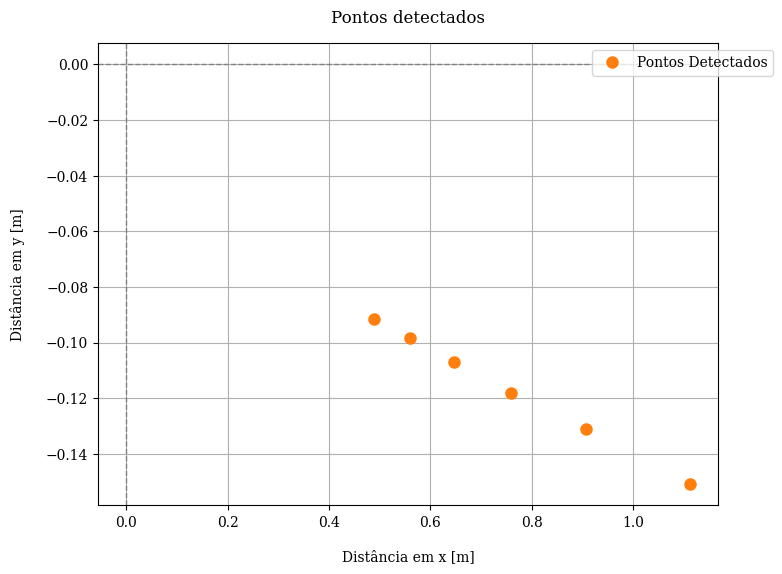

<Figure size 640x480 with 0 Axes>

In [111]:
# ------------------------------------------------------
#  Plot pontos detectados

plt.figure(figsize=(8, 6))
plt.plot([], [], 'o-', markersize=8)
plt.plot(Xc, Yc, 'o', label='Pontos Detectados', markersize=8)

plt.rcParams['font.family'] = 'serif'

plt.axhline(0, color='gray', linewidth=1, linestyle='--')  # Linha horizontal
plt.axvline(0, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.xlabel('Distância em x [m]', labelpad=15)
plt.ylabel('Distância em y [m]', labelpad=15)

plt.title('Pontos detectados', pad=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), borderaxespad=0.5)

plt.grid(True)
plt.savefig(plt_path + 'detected_points_plot')
plt.show()
plt.clf()

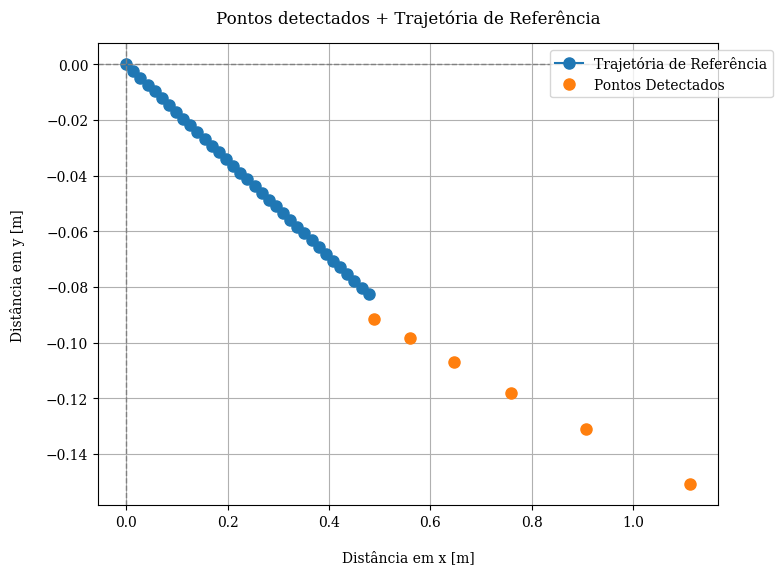

<Figure size 640x480 with 0 Axes>

In [112]:
# ------------------------------------------------------
#  Plot pontos detectados + Trajetória de Referência
plt.figure(figsize=(8, 6))
plt.plot(x_smooth, y_smooth, 'o-', label='Trajetória de Referência', markersize=8)
plt.plot(Xc, Yc, 'o', label='Pontos Detectados', markersize=8)

plt.rcParams['font.family'] = 'serif'
# Adicionando linhas verticais e horizontais passando pela origem (0, 0)
plt.axhline(0, color='gray', linewidth=1, linestyle='--')  # Linha horizontal
plt.axvline(0, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.xlabel('Distância em x [m]', labelpad=15)
plt.ylabel('Distância em y [m]', labelpad=15)
# plt.title('Pontos detectados + Trajetória de Referência', pad=15)
plt.title('Pontos detectados + Trajetória de Referência', pad=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), borderaxespad=0.5)

plt.grid(True)
plt.savefig(plt_path + 'trajectory')
plt.show()
plt.clf()

self.R 0.05
self.L 0.1


out_X [0, 0.014071705260410966, 0.028143131357485637, 0.0422149157710041, 0.05628642812569943, 0.07035807403760498, 0.08442970587674711, 0.09850129349955981, 0.11257291976448713, 0.12664453746520501, 0.1407161499184323, 0.15478775144960866, 0.16885940977552513, 0.1829309596750348, 0.1970026235753987]
out_Y [0, -0.0024301996089834406, -0.00486204886261188, -0.007291788803987867, -0.009723113508220221, -0.012153663043335022, -0.014584298345872299, -0.01701518874685851, -0.01944585454581909, -0.02187657062308259, -0.02430731697897773, -0.02673812641486037, -0.029168604763586122, -0.03159971640280081, -0.03403016695104872]
out_v_R [0.11458595672421164, 0.2854830908437729, 0.28575000724740185, 0.28548766526737585, 0.2856553552218391, 0.28559419836146616, 0.2855821506807872, 0.28561624068613684, 0.2855967120408551, 0.28559813154242875, 0.28559579994131373, 0.2856237965411641, 0.2855552861445807, 0.2856472555134145, 0.05213763881183416]
out_v_L [0.45661446678901063, 0.28571739794603973, 0.285

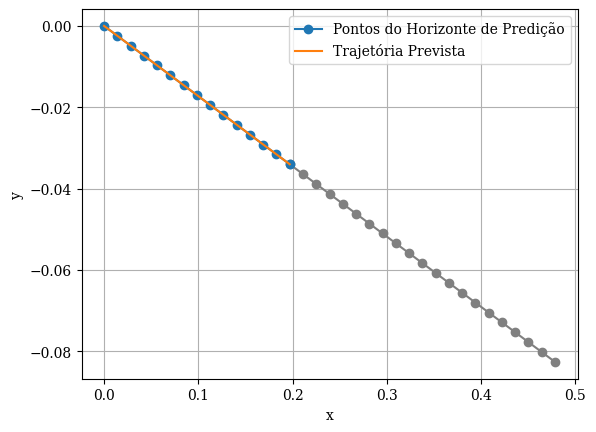

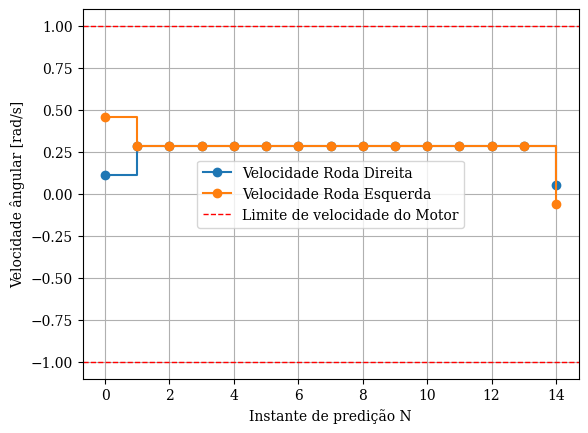

<Figure size 640x480 with 0 Axes>

In [113]:

# # Trajetória interpolada
x_ref = x_smooth
y_ref = y_smooth

# # # Simulação
dt = delta_time
x_traj = [0]
y_traj = [0]
v_out = []

robot_2 = DifferentialDriveRobot(radius_wheel, distance_wheel)
mpc_2 = MPCController(robot_2, N=predict_horizon, Q=1, R=0, dt=delta_time, max_margin=margin)
v_R, v_L, [out_x, out_y], [out_v_R, out_v_L] = mpc_2.solve(x_ref[0:predict_horizon], y_ref[0:predict_horizon], disable_constrain=True)
v_out.append((v_R, v_L))
robot.update(v_R, v_L, dt)
x_traj.append(robot.x)
y_traj.append(robot.y)

# Plotar trajetória 
plt.plot(x_ref[predict_horizon - 1:], y_ref[predict_horizon - 1:], 'o-',color='grey')
plt.plot(x_ref[0:predict_horizon], y_ref[0:predict_horizon], 'o-', label='Pontos do Horizonte de Predição')
plt.plot(out_x, out_y, '-', label='Trajetória Prevista')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_predicted')
plt.show()
plt.clf() 

# Plotar Velocidade
plt.step(range(len(out_v_R)), out_v_R, 'o-', where='post', label='Velocidade Roda Direita')
plt.step(range(len(out_v_L)), out_v_L, 'o-', where='post', label='Velocidade Roda Esquerda')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('Instante de predição N')
plt.ylabel('Velocidade ângular [rad/s]')
plt.axhline(1, color='red', linewidth=1, linestyle='--', label='Limite de velocidade do Motor')  # Linha horizontal
plt.axhline(-1, color='red', linewidth=1, linestyle='--')  # Linha horizontal
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_velocity')
plt.show()
plt.clf() 


self.R 0.05
self.L 0.1
out_X [0, 0.01407162654249365, 0.028143229907232913, 0.042214845306021674, 0.05628645966410471, 0.07035807457873715, 0.08442968961869794, 0.09850130447962081, 0.11257291943225155, 0.1266445343551327, 0.1407161492875822, 0.15478776420710802, 0.16885937914814053, 0.18293099406629174, 0.19700257828388354]
out_Y [0, -0.002430643047760859, -0.004861471671820595, -0.0072921929411340425, -0.00972292859742303, -0.012153660707187043, -0.014584392115638433, -0.017015124571154453, -0.01944585649474958, -0.021876588592726683, -0.024307320634582092, -0.026738052751521385, -0.029168784740698412, -0.031599516879010484, -0.0340302435975617]
out_v_R [0.1145543904749224, 0.28558724615878955, 0.2856077923880648, 0.2855992790792047, 0.2856005347163806, 0.28560033347718555, 0.2856002092729806, 0.2856003214584604, 0.28560027127453913, 0.28560028764653944, 0.2856002783251327, 0.28560029272159426, 0.28560027313407277, 0.28559966824612576, -9.399014491694603e-18]
out_v_L [0.4566459759956

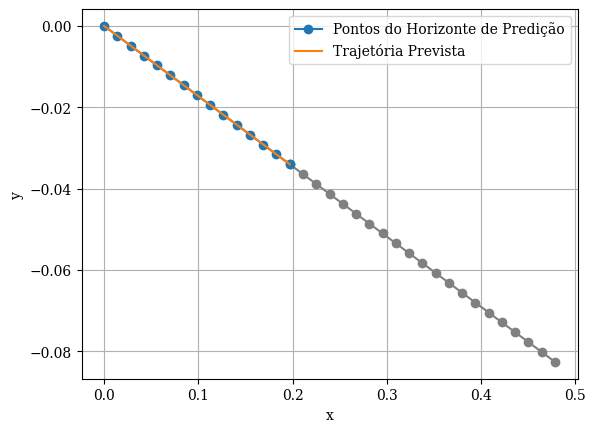

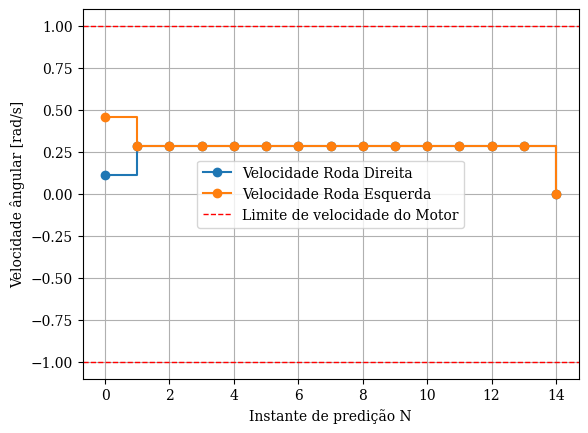

<Figure size 640x480 with 0 Axes>

In [114]:

# # Trajetória interpolada
x_ref = x_smooth
y_ref = y_smooth

# # # Simulação
dt = delta_time
x_traj = [0]
y_traj = [0]
v_out = []

robot_constrained = DifferentialDriveRobot(radius_wheel, distance_wheel)
mpc_constrained = MPCController(robot_constrained, N=predict_horizon, Q=1, R=0, dt=delta_time, max_margin=margin)

v_R, v_L, [out_x, out_y], [out_v_R, out_v_L] = mpc_constrained.solve(x_ref[0:predict_horizon], y_ref[0:predict_horizon], disable_constrain=False)
v_out.append((v_R, v_L))
robot_constrained.update(v_R, v_L, dt)
x_traj.append(robot_constrained.x)
y_traj.append(robot_constrained.y)

# Plotar trajetória 
plt.plot(x_ref[predict_horizon - 1:], y_ref[predict_horizon - 1:], 'o-',color='grey')
plt.plot(x_ref[0:predict_horizon], y_ref[0:predict_horizon], 'o-', label='Pontos do Horizonte de Predição')
plt.plot([0] + out_x, [0] + out_y, '-', label='Trajetória Prevista')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_predicted_constrained')
plt.show()
plt.clf() 

# Plotar Velocidade
plt.step(range(len(out_v_R)), out_v_R, 'o-', where='post', label='Velocidade Roda Direita')
plt.step(range(len(out_v_L)), out_v_L, 'o-', where='post', label='Velocidade Roda Esquerda')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('Instante de predição N')
plt.ylabel('Velocidade ângular [rad/s]')
plt.axhline(1, color='red', linewidth=1, linestyle='--', label='Limite de velocidade do Motor')  # Linha horizontal
plt.axhline(-1, color='red', linewidth=1, linestyle='--')  # Linha horizontal
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_velocity_constrained')
plt.show()
plt.clf() 


self.R 0.05
self.L 0.1
out_X [0, 0.029418265448481785, 0.06555172592266179, 0.09709344833343674, 0.1307963203311091, 0.16349548126733032, 0.1961946230058167, 0.2288937277015641, 0.2615928323141537, 0.29429193687378247, 0.32699104138929025, 0.3596901458678927, 0.3923892503157452, 0.42508835663666156, 0.4577873408743195]
out_Y [0, 0.011381075075261012, 0.014828275376269243, 0.006664995845992382, -0.010361196683541293, -0.023227655021021552, -0.03496345266261669, -0.04561970842398825, -0.05524595518724559, -0.06389177502849425, -0.0716067500574766, -0.07844046238099396, -0.08444249410141658, -0.0896624134720837, -0.0941498455486352]
out_v_R [0.9999980776225641, 0.4519271491230985, 0.3032532230722325, 0.5406535702624959, 0.795703268154431, 0.7251168004582377, 0.7173818423052815, 0.7104661699930808, 0.7042667793534743, 0.6987271581250822, 0.6937896641418955, 0.6893975870133553, 0.6854959148345795, 0.6820258685005917, -1.084421696907576e-17]
out_v_L [0.2617234203282762, 0.9999737592204283, 0

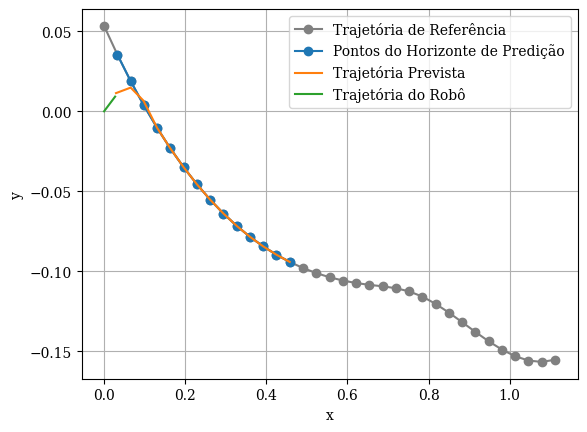

out_X [0.027206386043863745, 0.06657538409565743, 0.09716413659452239, 0.13079629205779714, 0.1634954835214481, 0.19619462300472498, 0.22889372770153396, 0.26159283231415376, 0.29429193687378247, 0.32699104138929025, 0.3596901458679458, 0.39238925031539224, 0.4250883547365118, 0.4577874606308845, 0.49048644611097697]
out_Y [0.009187751676672963, 0.014138836509356507, 0.006511351942573773, -0.010361066993445408, -0.02322765256399162, -0.03496345266471465, -0.045619708424052524, -0.05524595518724555, -0.06389177502849426, -0.07160675005747653, -0.07844046238070504, -0.08444249410344326, -0.08966242732709763, -0.09414983128518792, -0.09795432938837145]
out_v_R [0.5930057380361522, 0.2610313748344829, 0.531927789772034, 0.792901456990033, 0.7251197344610423, 0.7173819309298889, 0.7104661699295697, 0.7042667793514126, 0.6987271581250846, 0.693789664150539, 0.6893975869342297, 0.6854954988930934, 0.6820299699107342, 0.6789443334398829, -8.285695516820929e-17]
out_v_L [0.994158390229143, 0.99

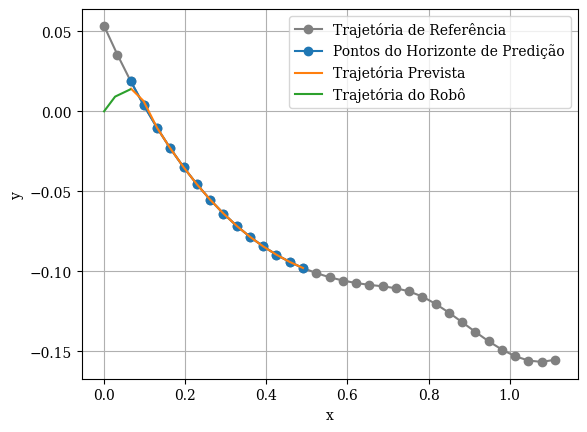

out_X [0.06389316438543426, 0.09660564182315508, 0.13071204260198563, 0.1634957570385564, 0.1973666160778424, 0.23737140161091616, 0.2773827471305823, 0.32166600749229035, 0.3677599954196131, 0.3677599987480588, 0.36776008772317703, 0.3918514333604192, 0.43184677785401004, 0.47626959827565857, 0.5195566500512855]
out_Y [0.013622878013758322, 0.006628452998480755, -0.009939043680593422, -0.023227093598730833, -0.029549393009199895, -0.03820914139215301, -0.05320509410381668, -0.07181703187166012, -0.09119022939844586, -0.09119024845511037, -0.09119016660461432, -0.08530157852121327, -0.08368952987799401, -0.08676542275195544, -0.09499513199817085]
out_v_R [0.3380862842913218, 0.5168010138124116, 0.7745888046165517, 0.8896701680427886, 0.7899833376855144, 0.7091743745749207, 0.9214222871702632, 0.9999911727199882, -0.9999987127438527, -0.9999996084465027, -0.9999996370399765, -0.9999994222058939, -0.9999986910763606, -0.9999946896829068, 2.0790804288597628e-17]
out_v_L [0.999988841406375

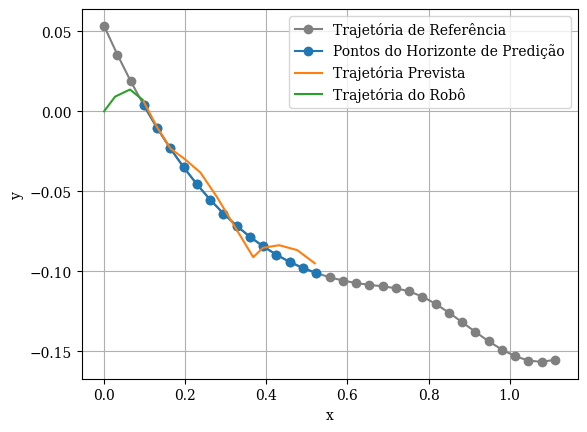

out_X [0.09460882201648266, 0.1303640927664372, 0.16349555064777235, 0.19619460387345264, 0.22889372769831115, 0.2615928323145928, 0.29429193687377353, 0.32699104138929075, 0.3596901458679458, 0.3923892503154349, 0.42508835473626294, 0.4577874591340237, 0.490486563511904, 0.5231856687323815, 0.5558846560913615]
out_Y [0.007314983762146397, -0.00863166360545484, -0.023227515788823073, -0.03496348302348183, -0.04561970843026451, -0.05524595518651322, -0.06389177502849587, -0.07160675005747648, -0.07844046238070498, -0.08444249410317604, -0.08966242732872637, -0.09414984416051546, -0.09795432669871221, -0.10112544616006106, -0.10371282199471925]
out_v_R [0.5660332775334255, 0.728636284366821, 0.7652002529395115, 0.7173884846130523, 0.7104651587240287, 0.7042667790961665, 0.6987271581496997, 0.693789664150412, 0.6893975869422427, 0.68549549882725, 0.6820295827310033, 0.6789479391321297, 0.6762012005500998, 0.6737377607769175, -7.388731926370306e-17]
out_v_L [0.9999730062948006, 0.719525154

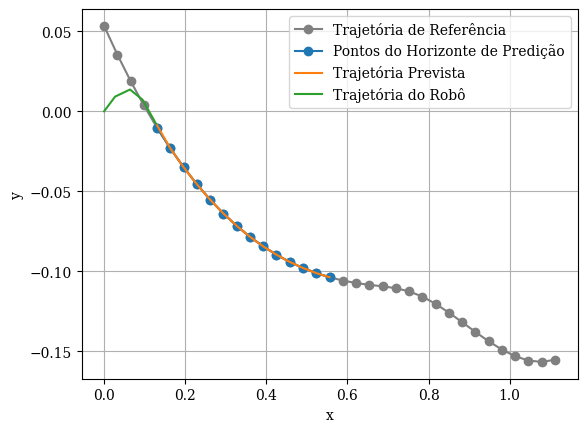

out_X [0.1278808809645798, 0.1634955309105266, 0.1961945847599961, 0.2288937312848767, 0.2615928300778803, 0.2942919369972143, 0.3269910414485393, 0.3596901458648275, 0.3923892503156629, 0.4250883547428988, 0.45778745913885566, 0.49048656346938285, 0.523185667775053, 0.5558847743326376, 0.5885837595071073]
out_Y [-0.007656094126532098, -0.023227456794980072, -0.034963520335005306, -0.045619689375496306, -0.055245960455057246, -0.0638917747858125, -0.07160674989239063, -0.07844046239244028, -0.08444249409918889, -0.08966242728291623, -0.09414984414999125, -0.09795432729448822, -0.10112545416187314, -0.10371281176033081, -0.10576599299048886]
out_v_R [0.7880448878629744, 0.7624094898077987, 0.7173929097117947, 0.710462673969685, 0.7042677038062669, 0.6987269791898446, 0.6937896607748604, 0.6893975929977045, 0.6854954996161094, 0.6820295804464083, 0.6789479221901541, 0.6762009878644012, 0.6737411726521523, 0.6715213225706234, 3.812241793808622e-16]
out_v_L [0.76675178043763, 0.62724527034

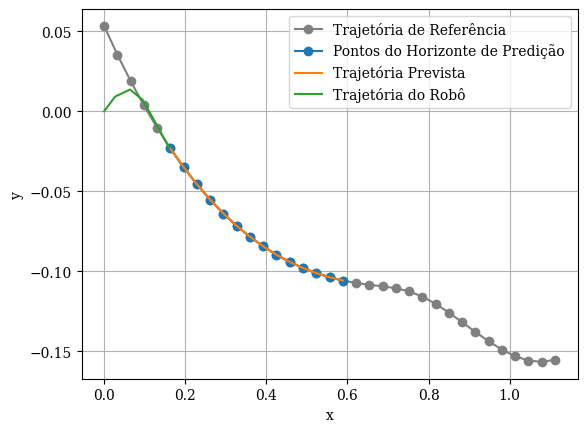

out_X [0.1605141903569056, 0.196194440034431, 0.22889374829786766, 0.2615928198876089, 0.29429193847149626, 0.3269910415617096, 0.35969014573082086, 0.3923892503419032, 0.42508835475756807, 0.4577874590048724, 0.4904865636548538, 0.5231856683444205, 0.555884767810143, 0.5885838892149481, 0.6212828572027087]
out_Y [-0.02271759534925906, -0.03496363776229287, -0.04561965173142798, -0.055245977365437564, -0.06389177134616836, -0.07160674943262244, -0.07844046284868426, -0.08444249400316016, -0.08966242716926072, -0.09414984513059618, -0.09795432606558764, -0.10112545093628321, -0.10371285241102669, -0.10576592780790443, -0.10733458563052946]
out_v_R [0.8562540074053113, 0.7034277971841173, 0.7104548024157835, 0.704270246300127, 0.6987262007961184, 0.6937897269322127, 0.6893976397194166, 0.6854954825934914, 0.6820295465476484, 0.6789480246099795, 0.6762009854440975, 0.6737396896258032, 0.6715287466832053, 0.6695000523443347, 1.434026779701415e-18]
out_v_L [0.6526769791965924, 0.67224350908

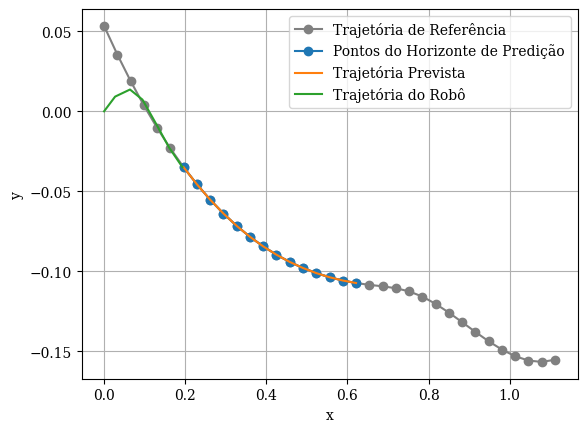

out_X [0.19308752789746564, 0.22889361389524293, 0.2615928557096315, 0.2942919227182085, 0.3269910435731875, 0.35969014584267534, 0.3923892502695618, 0.4250883547308391, 0.4577874591374769, 0.49048656352472375, 0.5231856678730104, 0.5558847721336772, 0.588583876417906, 0.6212829831580616, 0.6539819683028674]
out_Y [-0.034871097163724385, -0.045619853364627344, -0.05524588447493197, -0.06389180226811632, -0.0716067443153965, -0.07844046241945592, -0.08444249426855899, -0.0896624273580852, -0.09414984414040271, -0.09795432657446901, -0.10112545704041041, -0.10371281893454079, -0.10576598217646656, -0.10733455873277843, -0.10847003934639358]
out_v_R [0.813172864470506, 0.6870738784672907, 0.7042561326769813, 0.6987314631617543, 0.6937883942529565, 0.6893977660387756, 0.6854955073046199, 0.6820295800448113, 0.678947940730338, 0.6762008652880115, 0.6737411102794224, 0.6715245908885668, 0.669508137265505, 0.667595838573257, 6.749213289476861e-16]
out_v_L [0.6822127200112942, 0.67639241897905

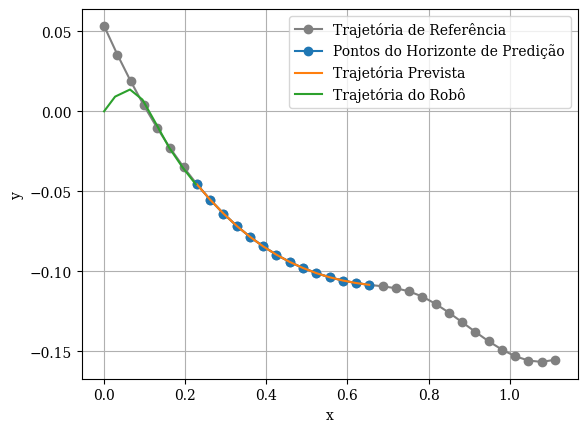

out_X [0.22588645581730227, 0.26159276135047804, 0.29429194979677153, 0.3269910347739305, 0.35969014689469014, 0.39238925029900357, 0.4250883547140325, 0.45778745913012475, 0.49048656350880937, 0.5231856678896961, 0.5558847722626145, 0.5885838762407083, 0.6212829811929407, 0.6539820874973319, 0.6866810723747974]
out_Y [-0.045567231766404225, -0.05524603879645147, -0.06389173396363235, -0.07160676379111704, -0.07844045931122995, -0.08444249414587258, -0.08966242741605306, -0.09414984418411344, -0.09795432674232575, -0.10112545688306177, -0.10371281655856687, -0.10576599403858743, -0.10733453524034296, -0.10847006315471326, -0.10938500312424425]
out_v_R [0.7904285662766919, 0.6826772279645442, 0.6987210541077787, 0.6937919981773907, 0.6893969405979562, 0.6854955952241756, 0.6820295862678767, 0.6789479366047735, 0.6762008790350906, 0.6737411667745494, 0.6715241009902044, 0.6695095822825314, 0.667595870042695, 0.6609748738445729, 3.4745362983393166e-16]
out_v_L [0.6893657136128676, 0.67023

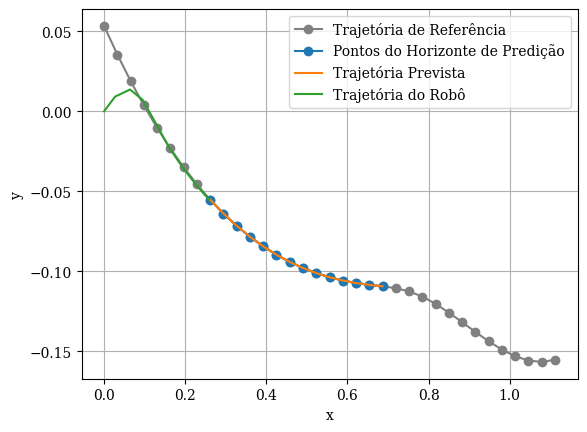

out_X [0.25864648454785105, 0.2942918752268894, 0.32699105144061574, 0.3596901408448857, 0.3923892510745173, 0.425088354727969, 0.4577874591179498, 0.49048656350224035, 0.5231856678648035, 0.5558847722891611, 0.5885838764889991, 0.6212829804573478, 0.6539820839546964, 0.6866812013385428, 0.7193801688846545]
out_Y [-0.055236074773605384, -0.06389184908708637, -0.07160671496877793, -0.07844047363824673, -0.0844424915881507, -0.08966242734749581, -0.09414984422599444, -0.09795432677922054, -0.10112545719909015, -0.10371281626844008, -0.10576598960993083, -0.10733456059289624, -0.10846998811823477, -0.10938509879246781, -0.11057144430984119]
out_v_R [0.7823998432838966, 0.6784608221489137, 0.6937844117548153, 0.6893995344278337, 0.6854949734534028, 0.6820296604771181, 0.6789479402973562, 0.6762008705264372, 0.6737411939131045, 0.6715242078994821, 0.6695085578431607, 0.6675997376023869, 0.6609693070913247, 0.6461230811357588, 2.716636855587676e-16]
out_v_L [0.6848513083126816, 0.66541716929

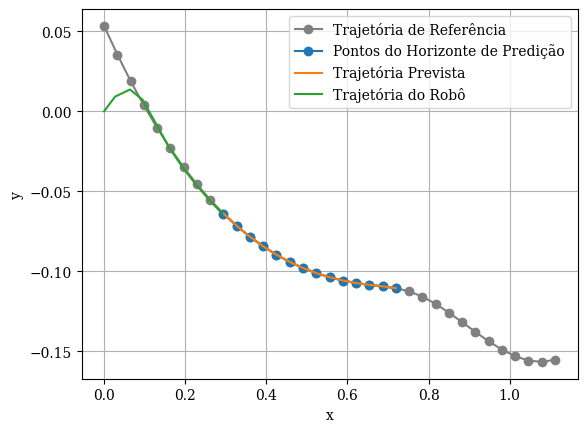

out_X [0.29137545621791755, 0.32699102392083346, 0.35969014789341974, 0.39238925086147386, 0.4250883551837853, 0.45778745949629573, 0.4904865638019108, 0.5231856681010544, 0.5558847723945674, 0.5885838766837759, 0.6212829810079942, 0.6539820852668575, 0.6866811896200146, 0.7193802936224488, 0.7520793565135263]
out_Y [-0.06395032409718102, -0.07160677046500577, -0.07844045941603478, -0.08444249597673105, -0.08966242905037032, -0.09414984574519462, -0.09795432815392019, -0.10112545837864943, -0.1037128185187513, -0.10576599065966091, -0.10733455575065563, -0.10847003680996105, -0.10938501303210187, -0.11057149673298353, -0.11254934818368276]
out_v_R [0.7770508260241252, 0.6738416608790984, 0.689396619903404, 0.6854956516370656, 0.6820295803681288, 0.6789479372901444, 0.6762008705311058, 0.673741154411804, 0.6715242780517788, 0.6695087033718498, 0.667597990577089, 0.6609748668197166, 0.6461178560554653, 0.6310326031148152, 1.6606442518995714e-16]
out_v_L [0.6801189424138262, 0.66238108297

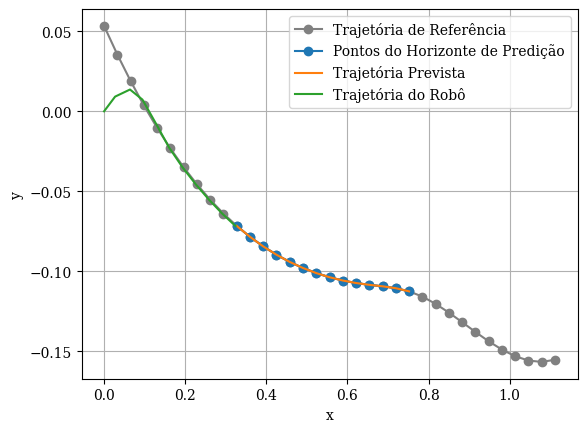

out_X [0.3240983248416093, 0.3596900980636299, 0.3923892543129751, 0.4250883540421424, 0.4577874592325126, 0.490486563504109, 0.523185667869059, 0.5558847722199094, 0.588583876545092, 0.6212829809764181, 0.6539820852462092, 0.6866811896515664, 0.7193802948954114, 0.7520793974665276, 0.7847783868296503]
out_Y [-0.0717365863600839, -0.07844051545807972, -0.0844424774104658, -0.08966242913677357, -0.09414984367774432, -0.09795432674017683, -0.10112545707327152, -0.10371281726794672, -0.10576598958420247, -0.10733455275251974, -0.10847003215610004, -0.1093850148326469, -0.11057148418217268, -0.11254940486775057, -0.1158089646873649]
out_v_R [0.7717793394166022, 0.6695530747740894, 0.6854925379928749, 0.6820302371618581, 0.6789478499742948, 0.6762008888042911, 0.6737411572100888, 0.6715242752347357, 0.669508767760843, 0.6675979814044269, 0.6609746235794487, 0.6461185046867508, 0.6310309865559802, 0.6182803341132096, 9.478371867357592e-18]
out_v_L [0.6769259986479651, 0.6602639517613433, 0.6

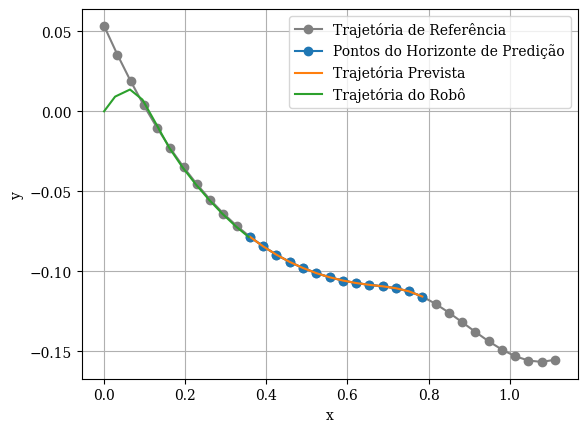

out_X [0.3568206385865094, 0.39238920551445444, 0.42508835816301377, 0.4577874585416911, 0.4904865635906192, 0.5231856678650487, 0.5558847722191081, 0.5885838765437461, 0.6212829809754158, 0.6539820852425153, 0.6866811897298283, 0.7193802947726375, 0.7520793991293194, 0.784778502249049, 0.8174774895796547]
out_Y [-0.0786372670147752, -0.08444254655301599, -0.08966241102575896, -0.0941498458210624, -0.09795432626169485, -0.10112545709822472, -0.10371281726863556, -0.10576598960131843, -0.10733455278808604, -0.10847003217854131, -0.10938501370197093, -0.11057149020351359, -0.11254936147766513, -0.11580905397976654, -0.12036040323527038]
out_v_R [0.7668375574483903, 0.6657530547432862, 0.682026709820217, 0.6789485680254541, 0.6762007905870306, 0.6737411734993285, 0.6715242739964284, 0.6695087677195664, 0.6675979822971787, 0.6609746592655612, 0.6461182537648115, 0.6310327045485646, 0.6182776458279512, 0.6213428241630684, -1.569208901737948e-17]
out_v_L [0.6747305948421951, 0.65877344628934

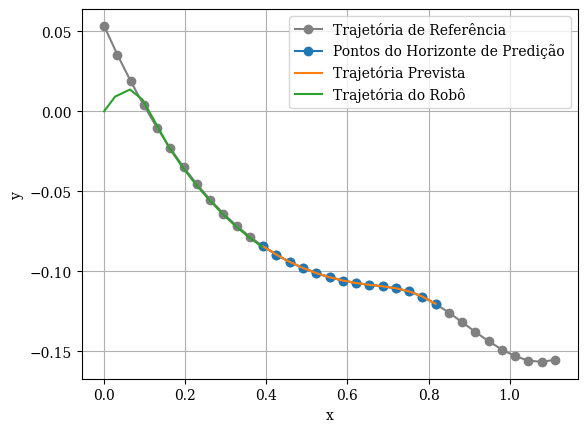

out_X [0.3895420727471939, 0.4250883125697683, 0.4577874620541708, 0.49048656299960297, 0.5231856679341446, 0.5558847722150111, 0.5885838765447544, 0.6212829809750576, 0.653982085238004, 0.6866811897311804, 0.7193802948965838, 0.752079399139673, 0.784778502254226, 0.8174776048312319, 0.8501765954874237]
out_Y [-0.08470186910624936, -0.08966247917907971, -0.09414982819173282, -0.09795432824911164, -0.1011254566511437, -0.10371281730348664, -0.10576598958232572, -0.10733455275933128, -0.10847003244780797, -0.10938501348030598, -0.11057148866230078, -0.112549372348068, -0.11580901485006204, -0.12036047420819185, -0.125823058242009]
out_v_R [0.762416748003496, 0.6623910195704894, 0.6789451434176427, 0.6762014801608986, 0.6737410822518464, 0.6715242905031966, 0.6695087663336808, 0.6675979730112536, 0.6609746834875498, 0.6461182814412698, 0.6310323001370796, 0.6182794818487004, 0.6213411038211184, 0.6358180768475619, 2.022884084632719e-17]
out_v_L [0.6732115080189747, 0.6578335939801122, 0.6

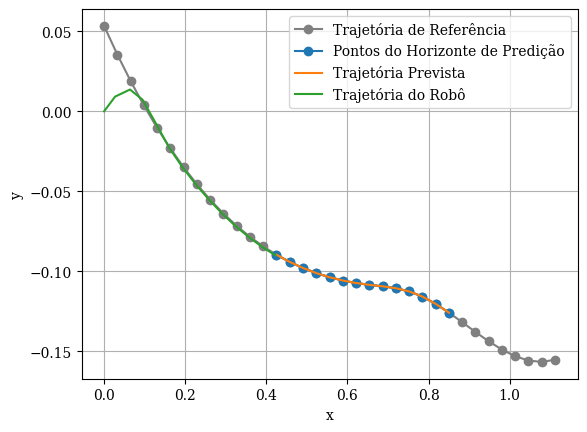

out_X [0.4222621653276553, 0.45778741925817024, 0.4904865659779238, 0.5231856674231101, 0.5558847722696522, 0.5885838765423447, 0.6212829809756188, 0.6539820852359002, 0.6866811897273238, 0.7193802948906595, 0.7520793992421821, 0.7847785019914666, 0.8174776063761586, 0.8501767101234081, 0.8828756991307604]
out_Y [-0.08998049990363743, -0.09414989552429152, -0.09795431099989453, -0.10112545852177007, -0.1037128168841589, -0.10576598960528603, -0.10733455274225225, -0.10847003249630847, -0.10938501349309925, -0.11057148870618216, -0.11254937134250996, -0.11580901956982888, -0.1203604553698322, -0.12582310676611336, -0.13180497671041247]
out_v_R [0.7585006751364143, 0.659398873762198, 0.6761981406414189, 0.6737417495943835, 0.6715242053604122, 0.6695087811637039, 0.6675979697784171, 0.6609746865654529, 0.6461182793630339, 0.6310323340543128, 0.6182792802066581, 0.6213419744217511, 0.6358183779619551, 0.6494256022754555, -1.2950403462440684e-17]
out_v_L [0.6722627660876036, 0.6573897901201

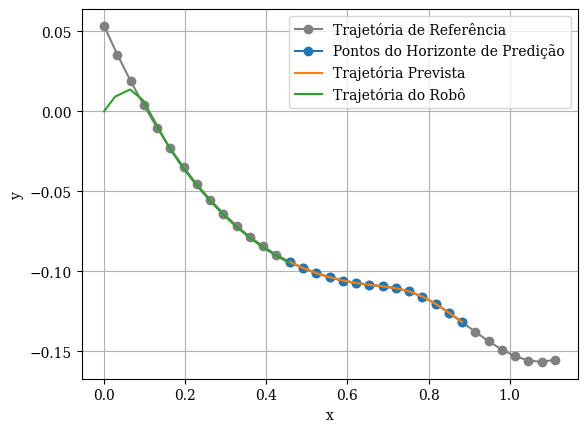

out_X [0.45498086954406347, 0.4904865174582838, 0.5231856736320876, 0.5558847670058776, 0.5885838771424929, 0.621282980972483, 0.6539820853345969, 0.686681189414732, 0.7193802951066671, 0.7520793998740893, 0.784778501695631, 0.8174776052859757, 0.8501767026480527, 0.8828758869465276, 0.9155747398208302]
out_Y [-0.09452283844800644, -0.09795442301637859, -0.10112540564451927, -0.10371283722765234, -0.10576598529952178, -0.10733455329935854, -0.10847003087054984, -0.1093850175331735, -0.11057148291681852, -0.11254937325225862, -0.11580902601915861, -0.1203604481867674, -0.12582310524365975, -0.13180501454992774, -0.13791422038158735]
out_v_R [0.7550203774656821, 0.6567284146502012, 0.6737341533868568, 0.6715273004257472, 0.6695078623919063, 0.6675981862598754, 0.6609744412745108, 0.6461187553376364, 0.6310318125056663, 0.618279366192812, 0.6213424604028024, 0.6358176705785592, 0.6494296903750433, 0.6615270373478708, -1.3038367952876965e-06]
out_v_L [0.6718232105157056, 0.6573732558855331

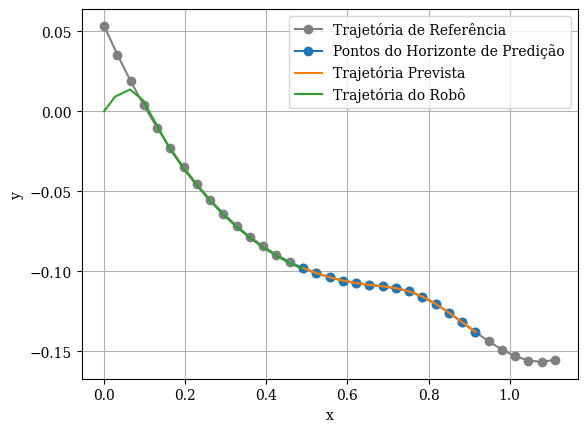

out_X [0.4876982278891428, 0.5231856550487007, 0.5558847729083667, 0.5885838766831332, 0.6212829810081157, 0.653982085267015, 0.6866811896200468, 0.7193802942066796, 0.7520793984941767, 0.7847785022477674, 0.8174776064419601, 0.8501767107823205, 0.8828758150632929, 0.9155749202438518, 0.9482739807069326]
out_Y [-0.09837845369153267, -0.10112547592793072, -0.10371281377854605, -0.10576599066488973, -0.10733455575013294, -0.10847003680354635, -0.10938501305042211, -0.11057148701663068, -0.11254936196015866, -0.11580901057382785, -0.12036045534589458, -0.12582310004797817, -0.1318050103774936, -0.13791424958201204, -0.1437588961314735]
out_v_R [0.7519226548214923, 0.6543195729527379, 0.6715234181529913, 0.6695088490960754, 0.6675979905770337, 0.6609748658974233, 0.6461181594084686, 0.6310325204339571, 0.6182790579847006, 0.6213417350694362, 0.6358188453796548, 0.6494272448557341, 0.661532972238907, 0.6721756845595049, -6.223745124479833e-07]
out_v_L [0.6718209274664589, 0.6577332466776454

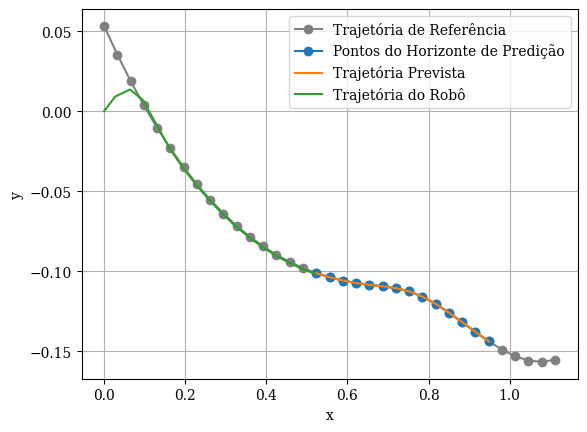

out_X [0.5204143234161036, 0.5558847376537965, 0.5885838778737714, 0.6212829806730368, 0.6539820852637027, 0.6866811897242676, 0.719380294892436, 0.7520793992274536, 0.784778502057066, 0.8174776061556516, 0.8501767105619421, 0.8828758151121106, 0.9155749184619834, 0.9482740290002399, 0.9809730072951615]
out_Y [-0.1015967473357933, -0.10371286756975306, -0.10576597441439316, -0.10733455399435318, -0.1084700321688953, -0.10938501350593166, -0.11057148870963672, -0.1125493715141768, -0.11580901893754428, -0.1203604574246301, -0.12582310149622855, -0.13180500951510923, -0.13791425751855496, -0.1437588729833153, -0.14894701637960636]
out_v_R [0.74913637475153, 0.65215326490137, 0.6695061801632873, 0.6675985273056774, 0.6609746271110809, 0.6461182901674772, 0.6310323284686236, 0.6182793099416444, 0.6213418707103879, 0.6358186755350298, 0.6494272925912712, 0.6615326268080554, 0.6721780125295682, 0.681679495635906, 1.359997142286935e-17]
out_v_L [0.6722028480232454, 0.6583879919434429, 0.63996

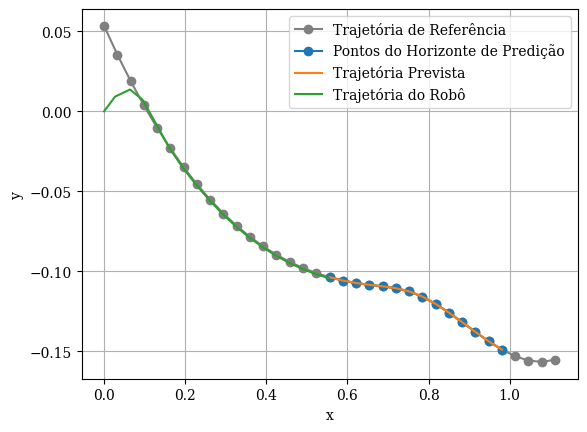

out_X [0.5531291102036587, 0.5885838433424746, 0.6212829820186381, 0.6539820849323599, 0.6866811897517225, 0.7193802948929985, 0.7520793992277047, 0.7847785020535402, 0.8174776061667028, 0.8501767105865282, 0.8828758149192001, 0.9155749194503717, 0.9482740224318343, 0.9809731351448635, 1.01367211008946]
out_Y [-0.10422742545944007, -0.10576603962092937, -0.10733453764120308, -0.10847003376033497, -0.10938501313776874, -0.11057148873091321, -0.1125493715208536, -0.11580901896363659, -0.12036045734179372, -0.12582310138273706, -0.13180501077631301, -0.13791425243793343, -0.1437589049155196, -0.1489469782787068, -0.15308668628134608]
out_v_R [0.7466325437438396, 0.6501732476118954, 0.6675954117378768, 0.6609752428207738, 0.6461182177777003, 0.6310323408082974, 0.6182793088616951, 0.6213418746208035, 0.6358186733114395, 0.6494272504091118, 0.6615328643765573, 0.67217666442069, 0.6816857853220848, 0.6906183439263306, -3.742747426341136e-17]
out_v_L [0.67289155993592, 0.6592961580716037, 0.6

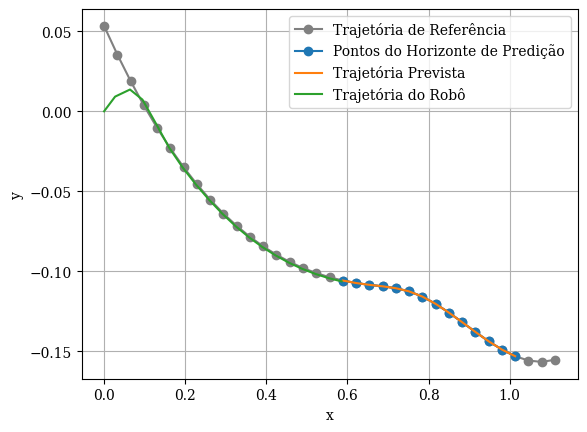

out_X [0.5858426596805604, 0.6212829489568888, 0.6539820860228929, 0.6866811894670916, 0.719380294889142, 0.7520793992271742, 0.7847785020553932, 0.817477606160597, 0.850176710604094, 0.882875814949121, 0.9155749192290348, 0.9482740237675332, 0.9809731265798858, 1.0136722409091536, 1.0463712130519383]
out_Y [-0.10631997162680278, -0.10733460237715628, -0.10847001769296095, -0.10938501457231348, -0.11057148841644383, -0.11254937152134467, -0.11580901897280627, -0.12036045738196505, -0.12582310127437774, -0.1318050106097049, -0.13791425407617608, -0.14375889789634227, -0.14894702336719226, -0.1530866212600475, -0.1557859659238384]
out_v_R [0.7443534274334901, 0.6482891986684061, 0.6609721803664836, 0.6461188111912637, 0.6310322779592797, 0.6182793182591635, 0.6213418738363826, 0.6358186787953476, 0.6494272477264373, 0.6615328095233253, 0.6721769879775686, 0.6816838923579823, 0.690626265942453, 0.6997661457470506, -1.824007375403231e-17]
out_v_L [0.6738389828937623, 0.6604645317497488, 0.

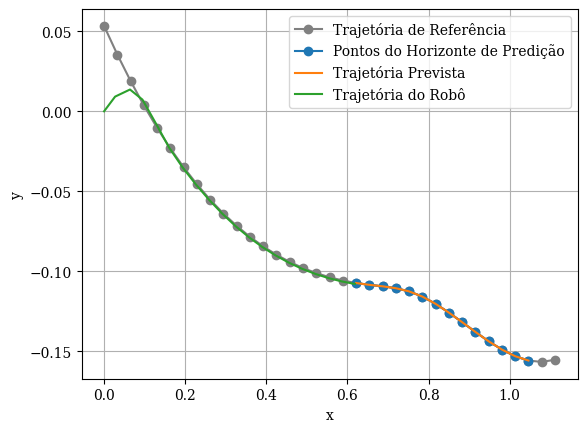

out_X [0.6185549881184326, 0.6539820544549397, 0.6866811900548284, 0.719380294712583, 0.7520793992230309, 0.7847785020568449, 0.8174776061637533, 0.8501767105964267, 0.882875814974119, 0.9155749192443773, 0.9482740235827891, 0.9809731282748493, 1.013672230537098, 1.046371347239984, 1.079070315367478]
out_Y [-0.10792393617355774, -0.10847008216268819, -0.10938499825229328, -0.11057149000717649, -0.11254937114288528, -0.1158090190102172, -0.12036045735480864, -0.12582310132914282, -0.13180501047488144, -0.13791425394257337, -0.1437588997769635, -0.1489470134090522, -0.1530866848131035, -0.15578586517829648, -0.1566529260532249]
out_v_R [0.7422038498306549, 0.6416809662444893, 0.6461157623038633, 0.6310328872224523, 0.618279246272719, 0.621341888221987, 0.6358186744200922, 0.6494272559640875, 0.6615328035010075, 0.6721769304087505, 0.6816843218320736, 0.6906236009884518, 0.6997763442004862, 0.7100582143130023, -4.945984197695526e-18]
out_v_L [0.6750471779415632, 0.6667963282475206, 0.6627

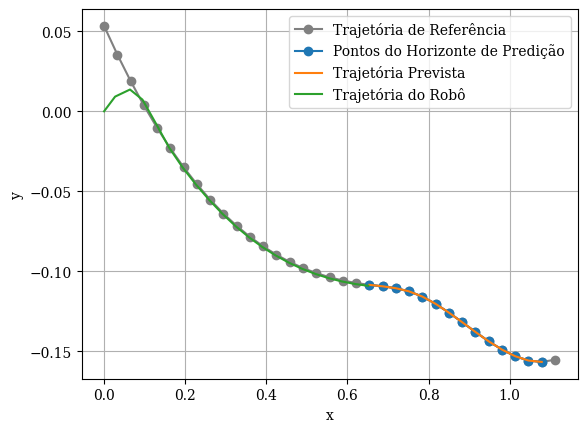

<Figure size 640x480 with 0 Axes>

In [115]:

# theta_ref = np.arctan2(np.gradient(y_ref), np.gradient(x_ref))
# x_margin_sup = x_ref + margin * np.cos(theta_ref + np.pi/2)
# y_margin_sup = y_ref + margin * np.sin(theta_ref + np.pi/2)
# x_margin_inf = x_ref - margin * np.cos(theta_ref + np.pi/2)
# y_margin_inf = y_ref - margin * np.sin(theta_ref + np.pi/2)

# print('iniciando simulação')
# print('len xref', len(x_ref))

# Parâmetros do ruído
ruido_intensidade = 0.005  # Ajuste o valor para controlar a intensidade do ruído

# Adiciona ruído gaussiano
x_ref_ruido = Xc + np.random.normal(0, ruido_intensidade, size=len(Xc))
y_ref_ruido = Yc + np.random.normal(0, ruido_intensidade, size=len(Yc))

# # Trajetória interpolada
cs = CubicSpline([0] + x_ref_ruido, [0] + y_ref_ruido)
x_smooth = np.linspace(0, Xc[-1], num=35)
y_smooth = cs(x_smooth)



x_ref = x_smooth
y_ref = y_smooth

# # # Simulação
dt = delta_time
x_traj = [0]
y_traj = [0]
v_out = []

robot_out = DifferentialDriveRobot(radius_wheel, distance_wheel)
mpc_out = MPCController(robot_out, N=predict_horizon, Q=1, R=0, dt=delta_time, max_margin=margin)


for i in range(len(x_ref) - predict_horizon):  # Garantir que o loop seja executado
    v_R, v_L, [out_x, out_y], [out_v_R, out_v_L] = mpc_out.solve(x_ref[i:i+predict_horizon], y_ref[i:i+predict_horizon])
    v_out.append((v_R, v_L))
    robot_out.update(v_R*0.9, v_L*0.95, dt)
    x_traj.append(robot_out.x)
    y_traj.append(robot_out.y)

    # Plotar trajetória com margem
    plt.plot(x_ref, y_ref, 'o-',color='grey', label='Trajetória de Referência')
    plt.plot(x_ref[i + 1: i + predict_horizon], y_ref[i + 1: i + predict_horizon], 'o-', label='Pontos do Horizonte de Predição')
    plt.plot(out_x[1:], out_y[1:], '-', label='Trajetória Prevista')
    plt.plot(x_traj, y_traj, '-', label='Trajetória do Robô')
    # plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.savefig(plt_path + f'simulation/trajectory_out_{i}')
    plt.show()
    plt.clf() 

# # v_R, v_L, out_x, out_y = mpc.solve(x_ref[0:predict_horizon], y_ref[0:predict_horizon])
# # v_out.append((v_R, v_L))
# # robot.update(v_R, v_L, dt)
# # x_traj.append(robot.x)
# # y_traj.append(robot.y)

# print('v_out', v_out)
# print('v_out.len', len(v_out))




